# DEFINE GOOGLE COLAB FLAG!

In [1]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [2]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [3]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,60000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [4]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [5]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [6]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

    !nvidia-smi

GPU total Memory    : 15843721216
GPU free Memory     : 14858059776
GPU Memory used     : 985661440
Thu Apr 29 22:23:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    940MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------------

## Mount the Google Drive to Google Colab

In [7]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/My Drive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DiabetesLearning/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


## Install Deep Learning libraries

In [8]:
# !pip install --upgrade fastai
# !pip install wandb

##restart runtime!!!

In [9]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Pytorch: 1.7.1
Fastai: 2.3.0


# Train your model

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import wandb
wandb.login()

wandb: Currently logged in as: bunoviske (use `wandb login --relogin` to force relogin)


True

## Data

In [11]:
path = path_to_drive + 'DiabetesLearning/dataset_v1_balanced/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [12]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/gt/113_Augmented_206_GT.png'), Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/gt/113_Augmented_211_GT.png'), Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/gt/113_Augmented_209_GT.png')]
[Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/done/108_Augmented_176.jpg'), Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/done/108_Augmented_178.jpg'), Path('/content/drive/My Drive/Colab Notebooks/DiabetesLearning/dataset_v1_balanced/done/108_Augmented_177.jpg')]


(23557, 23557)

In [13]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(codes)

117

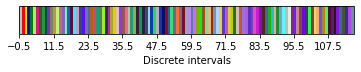

In [14]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

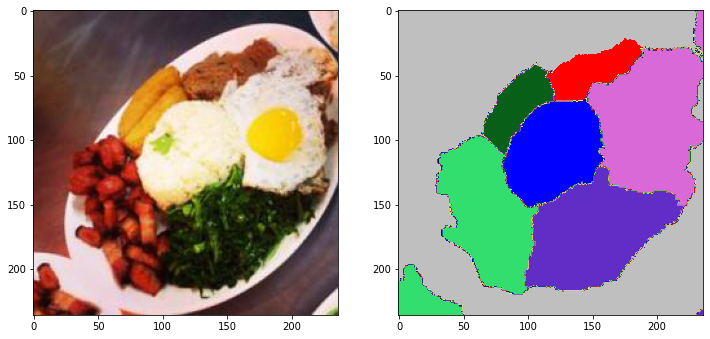

Ground truth Codes (array([  0,   1,   3,  53,  61,  80, 100], dtype=uint8), array([25371,  1849,  4691,  7004,  7878,  7061,  1842]))


In [15]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

idx = 30
fig = plt.figure(figsize=(12,12))

img = Image.open(fnames[idx])
arr = np.asarray(img)
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(arr)

img1 = Image.open(get_y_fn(fnames[idx]))
arr = np.asarray(img1)
ax1 = fig.add_subplot(1,2,2)
ax1.imshow(arr, cmap=cmap, norm=norm)
plt.show()

print("Ground truth Codes",np.unique(arr,return_counts=True))


## Data Augmentation

In [16]:
size = (400,400)
item_tfms = [Resize(size, method=ResizeMethod.Squish, resamples=(Image.NEAREST,Image.NEAREST))]
aug_tfms = aug_transforms(mult=1, flip_vert=True, size=size, min_scale=1.0, max_warp=0.1, max_lighting=0.1)

## Dataloaders

In [17]:
bs = 4 # batch size

# dataloaders = SegmentationDataLoaders.from_label_func(path, bs=bs,
#     fnames = X_train, 
#     label_func = get_y_fn,                                     
#     codes = codes,   
#     valid_pct=0.3,
#     seed=None,
#     item_tfms=item_tfms,                
#     batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])
# dataloaders.vocab = codes

from sklearn.model_selection import train_test_split
X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

datablock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FuncSplitter(lambda o: o in X_test),
                   get_y=get_y_fn,
                   item_tfms=item_tfms, 
                   batch_tfms=[*aug_tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders = datablock.dataloaders(path_img, path=path, bs=bs)

# for now, test dataloader is the same as validation
test_dl = dataloaders.test_dl(X_test, with_labels=True)
test_dl.vocab = codes

In [18]:
len(dataloaders.train_ds), len(dataloaders.valid_ds), len(X_test)

(18845, 4712, 4712)

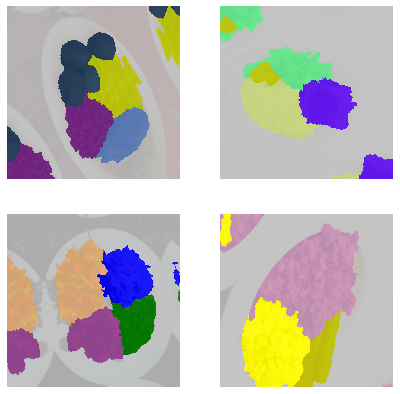

In [21]:
dataloaders.train.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
dataloaders.valid.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

In [ ]:
test_dl.show_batch(max_n=4, figsize=(7, 7), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [18]:
from fastaiMetrics import acc_segmentation, MIOU

classes_index = range(1, len(codes)) #exclude background class at index 0
metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

## Model

In [19]:
modelCallbacks = [ShowGraphCallback,EarlyStoppingCallback(patience=5)]
opt_func = ranger
classWeights = torch.ones(len(codes)).cuda() if isGoogleColab else torch.ones(len(codes))
classWeights[0] = 0.5
loss_func = CrossEntropyLossFlat(weight=classWeights, axis=1)

learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=metrics, cbs=modelCallbacks,
                       self_attention=True, act_cls=Mish)

In [ ]:
# learner.model[0].load_state_dict(torch.load(path_to_drive + 'DiabetesLearning/modelConfig/resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [20]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# test.model[0].
learner.load('stage-3-best')

## Training

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=0.0010000000474974513)

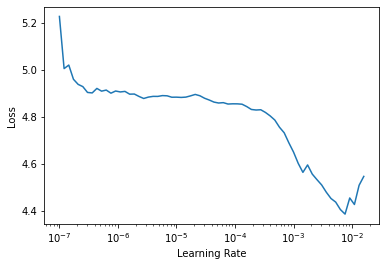

In [ ]:
learner.lr_find()

In [22]:
lr = 1e-3
epochs = 10
wd = 1e-2
learner.freeze()

/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


Better model found at epoch 0 with acc_segmentation value: 0.7216957211494446.


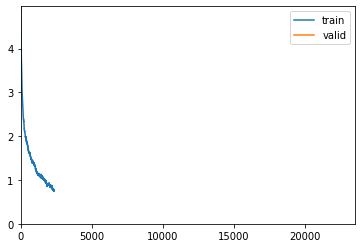

In [ ]:
run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-1-best',with_opt=True), GradientAccumulation(n_acc=16)]
# learner.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, slice(lr), wd=wd,cbs=fitCallbacks)
# learner.fine_tune(epochs, base_lr=lr, freeze_epochs=1, wd=wd, cbs=fitCallbacks)
# run.finish()

## Fine-tunning (optional)

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


In [23]:
learner.unfreeze()
# learner.lr_find()

In [24]:
lrs = slice(lr/400,lr/4)
epochs = 2
wd = 1e-2

In [26]:
run = wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-4-best',with_opt=True),GradientAccumulation(n_acc=16)]
# learner.fit_one_cycle(epochs, lrs, pct_start=0.8, wd=wd, cbs=fitCallbacks)
learner.fit_flat_cos(epochs, lrs, wd=wd, cbs=fitCallbacks)
run.finish()

Problem at: <ipython-input-26-228598d426b6> 1 <module>


KeyboardInterrupt: ignored

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [27]:
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-2-best')

In [28]:
print(learner.validate(dl=test_dl))

/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


[0.2872485816478729, 0.8910665512084961, 0.805517390128465, 0.6827605766215669]


/content/drive/My Drive/Colab Notebooks/DiabetesLearning/fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)


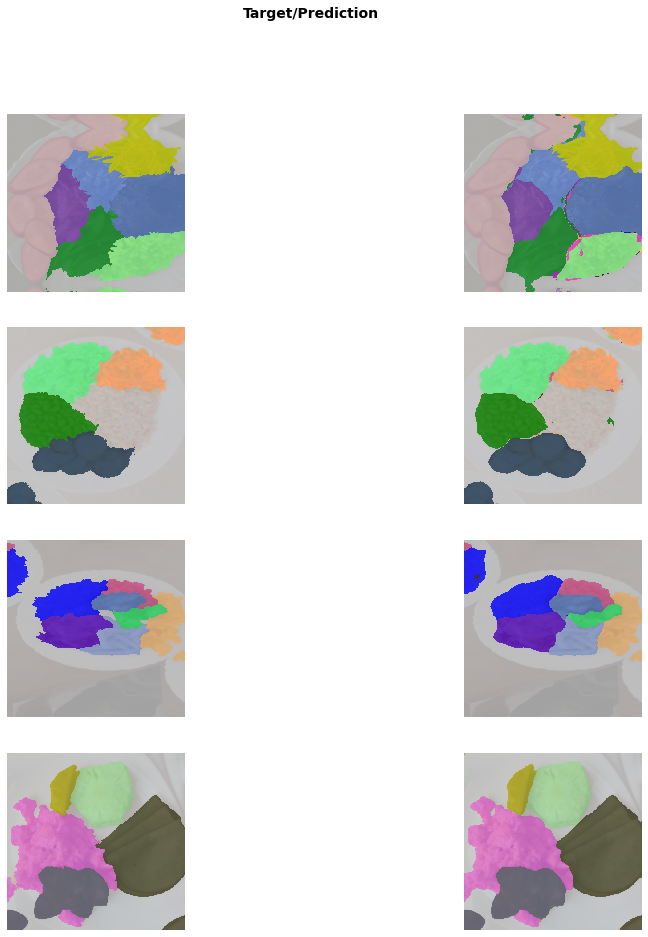

In [29]:
learner.show_results(dl=test_dl, figsize=(15,15), max_n=20, cmap=cmap, norm=norm,alpha=0.8)

In [30]:
interp = Interpretation.from_learner(learner, dl=test_dl)

RuntimeError: ignored

In [ ]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(4, figsize=(15,11), cmap=cmap, norm=norm)

In [ ]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [ ]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

# LOAD ONLY IF NECESSARY
# learner = unet_learner(dataloaders, resnet34, metrics=metrics)
# learner.load('stage-2-best')

In [21]:
input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=test_dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

RuntimeError: ignored

In [ ]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.7673861055003806


In [ ]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.7188432974612564


In [ ]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

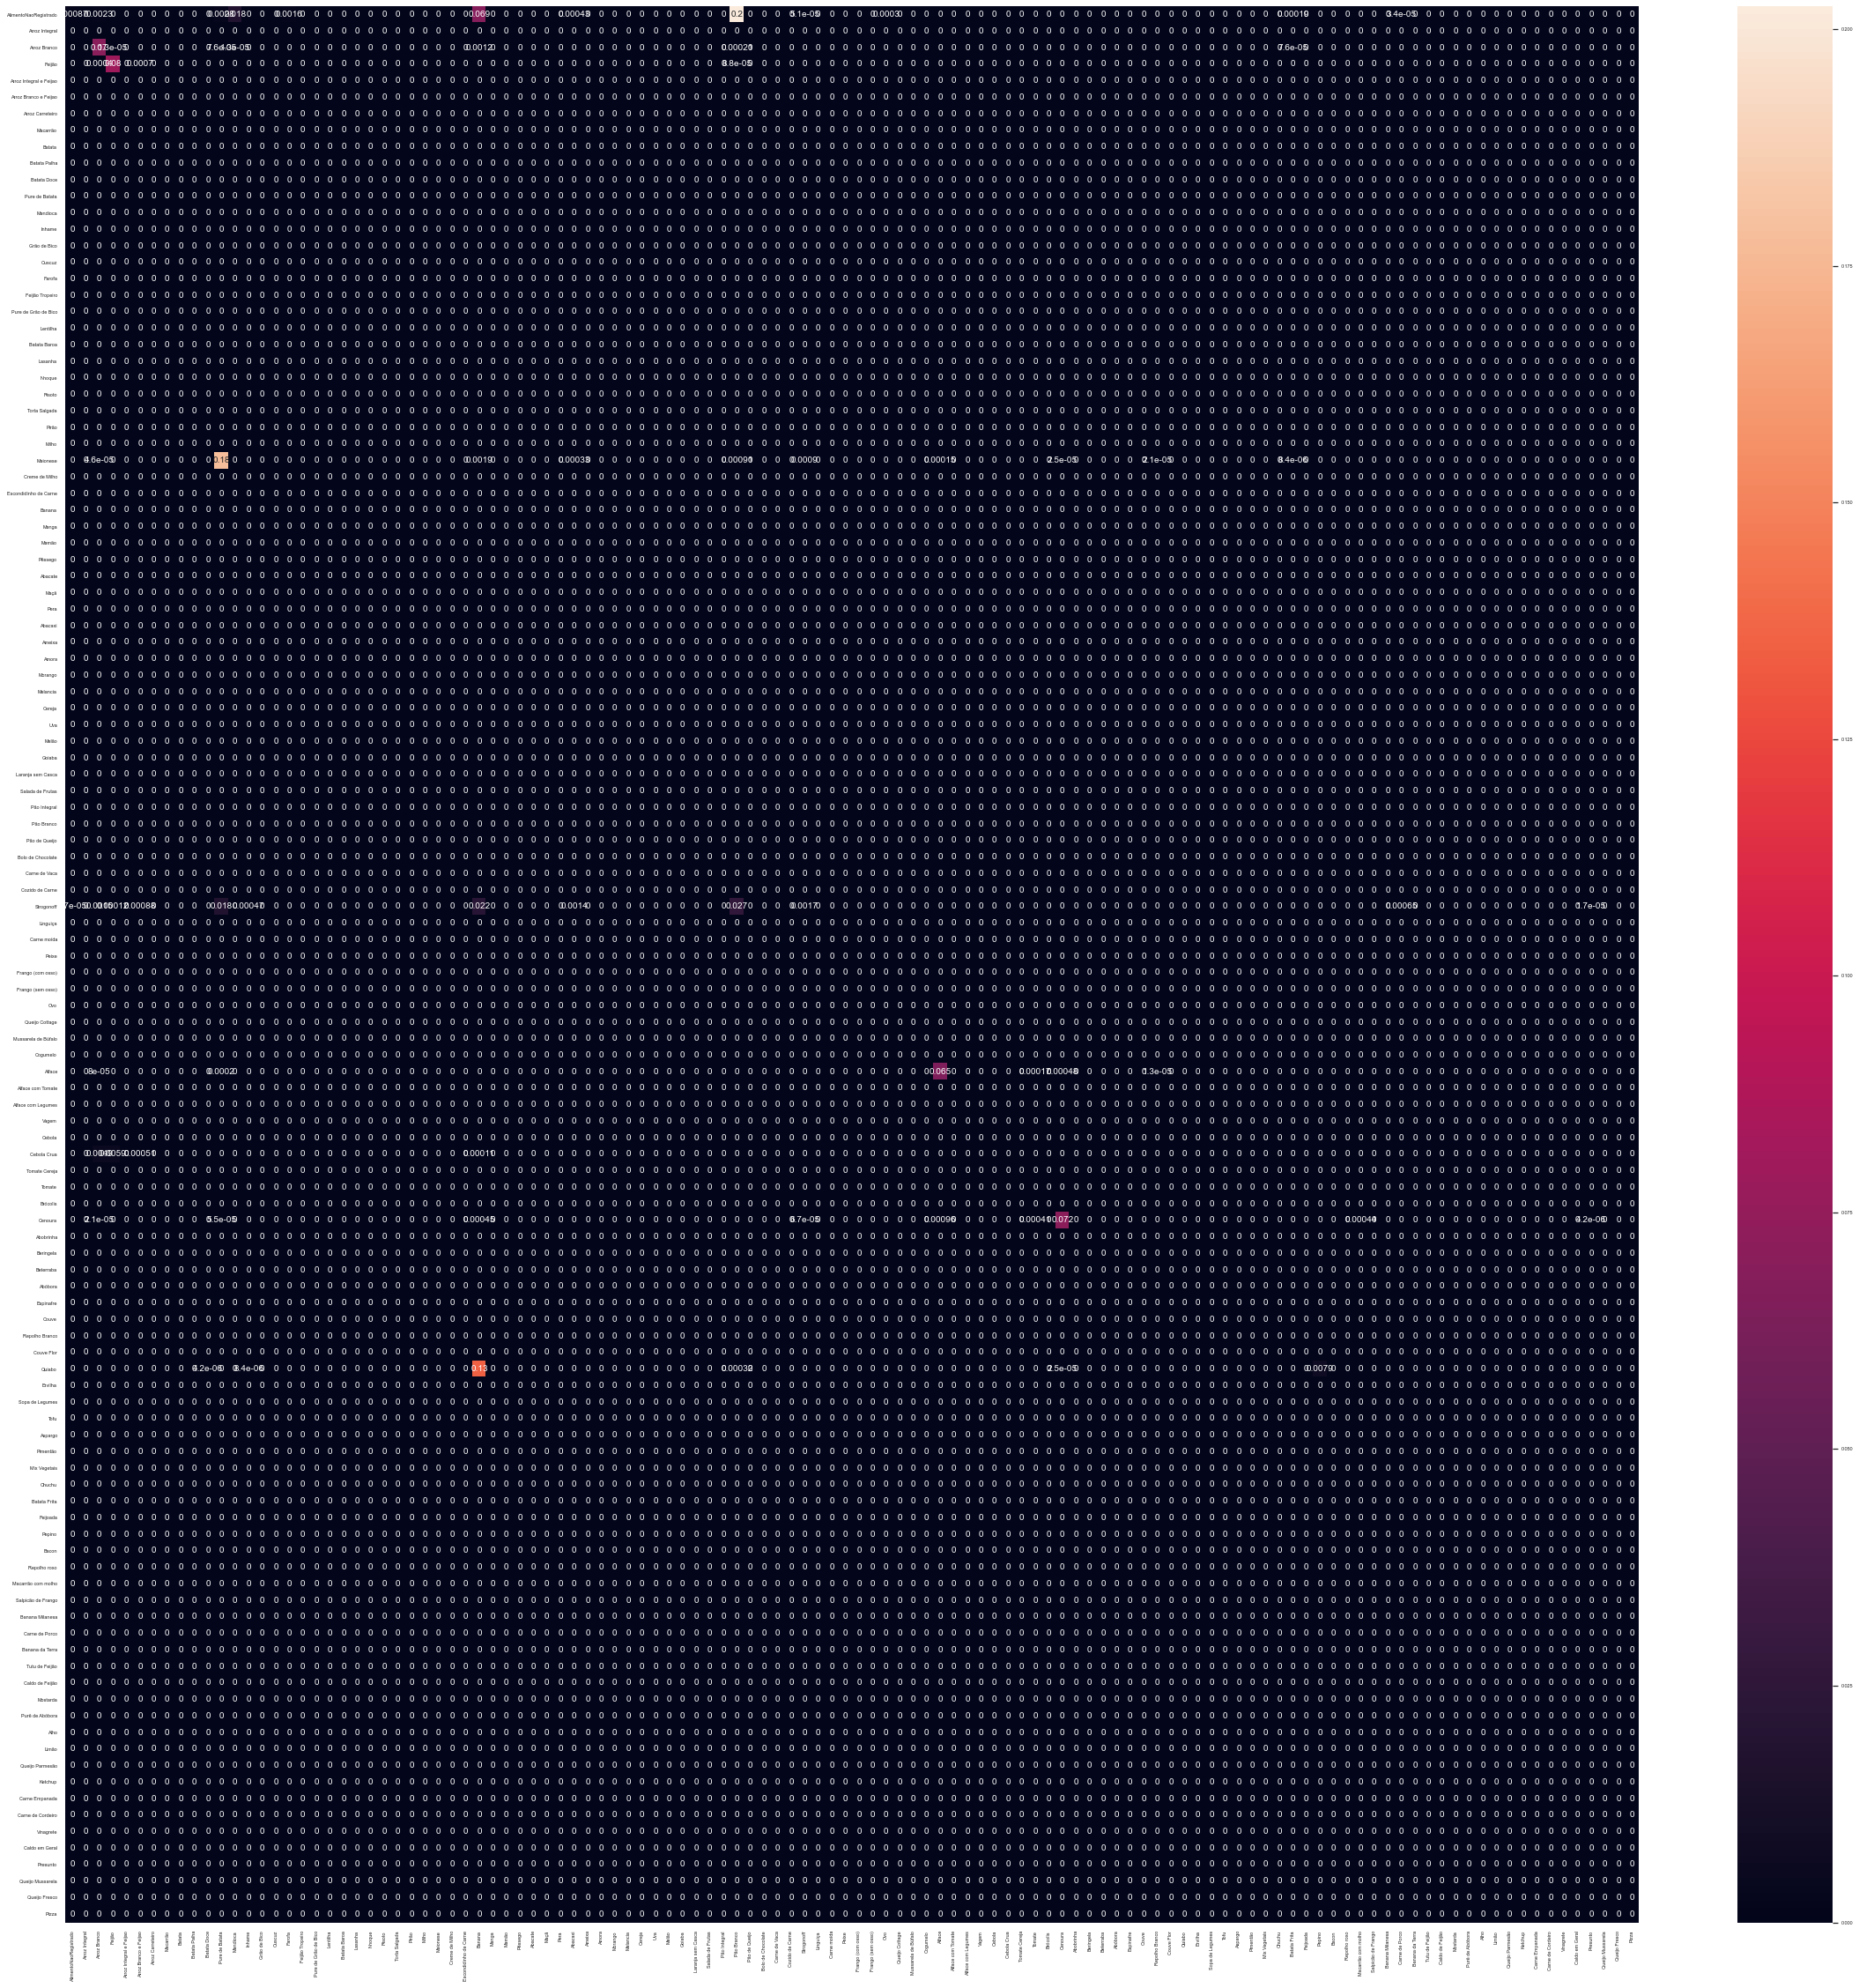

In [ ]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, codes)

In [ ]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

                         precision    recall  f1-score   support

  AlimentoNaoRegistrado       0.00      1.00      0.00         0
         Arroz Integral       0.00      1.00      0.00         0
           Arroz Branco       0.59      0.99      0.74     44341
                 Feijão       0.00      1.00      0.00         0
Arroz Integral e Feijao       0.00      1.00      0.00         0
  Arroz Branco e Feijao       0.94      0.73      0.82    133992
       Arroz Carreteiro       1.00      1.00      1.00         0
               Macarrão       0.00      1.00      0.00         0
                 Batata       0.00      1.00      0.00         0
           Batata Palha       0.00      1.00      0.00         0
            Batata Doce       0.00      1.00      0.00         0
         Pure de Batata       0.00      1.00      0.00         0
               Mandioca       1.00      1.00      1.00         0
                 Inhame       1.00      1.00      1.00         0
           Grão de Bico 

## Check some particular image details

In [ ]:
from collections import OrderedDict

id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


In [ ]:
idx = 0
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = input[idx]
nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [ ]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 169307), ('AlimentoNaoRegistrado', 22992), ('Feijão', 19310), ('Strogonoff', 19310), ('Arroz Branco', 17006), ('Cebola Crua', 14219)])


In [ ]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 15
OrderedDict([('NaoAlimento', 183950), ('Banana', 21230), ('Feijão', 20712), ('Arroz Branco', 19162), ('Pão Branco', 6597), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Arroz Branco e Feijao', 535), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])


In [ ]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 15
OrderedDict([('Banana', 12089), ('Pão Branco', 5688), ('NaoAlimento', 5118), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Feijão', 1711), ('Arroz Branco', 955), ('Arroz Branco e Feijao', 509), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])

Percentual de pixeis com baixa probabilidade

Banana 56.94 %
Pão Branco 86.22 %
NaoAlimento 2.78 %
Pure de Batata 100.00 %
Mandioca 100.00 %
Feijão 8.26 %
Arroz Branco 4.98 %
Arroz Branco e Feijao 95.14 %
Strogonoff 100.00 %
Abacaxi 100.00 %
Carne de Porco 100.00 %
Inhame 100.00 %
Batata Frita 100.00 %
AlimentoNaoRegistrado 100.00 %
Presunto 100.00 %


In [ ]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 178832), ('Feijão', 19001), ('Arroz Branco', 18207), ('Banana', 9141), ('Pão Branco', 909), ('Arroz Branco e Feijao', 26)])

Percentual de pixeis com alta probabilidade

NaoAlimento 97.22 %
Feijão 91.74 %
Arroz Branco 95.02 %
Banana 43.06 %
Pão Branco 13.78 %
Arroz Branco e Feijao 4.86 %


## Predictions of new input data

Numero de alimentos: 28
OrderedDict([('NaoAlimento', 121993), ('Alface', 12828), ('Tomate', 12486), ('Milho', 3356), ('Pure de Batata', 2674), ('Frango (sem osso)', 1473), ('Brócolis', 1421), ('Arroz Integral', 1179), ('Beterraba', 843), ('Ovo', 643), ('Cenoura', 484), ('Frango (com osso)', 220), ('Abóbora', 117), ('AlimentoNaoRegistrado', 82), ('Arroz Branco', 61), ('Purê de Abóbora', 44), ('Linguiça', 30), ('Arroz Integral e Feijao', 24), ('Feijão', 16), ('Mix Vegetais', 7), ('Pimentão', 5), ('Batata', 4), ('Caldo em Geral', 4), ('Carne de Vaca', 2), ('Laranja sem Casca', 1), ('Alface com Tomate', 1), ('Tomate Cereja', 1), ('Repolho Branco', 1)])

3 principais alimentos: ['Alface', 'Tomate', 'Milho']


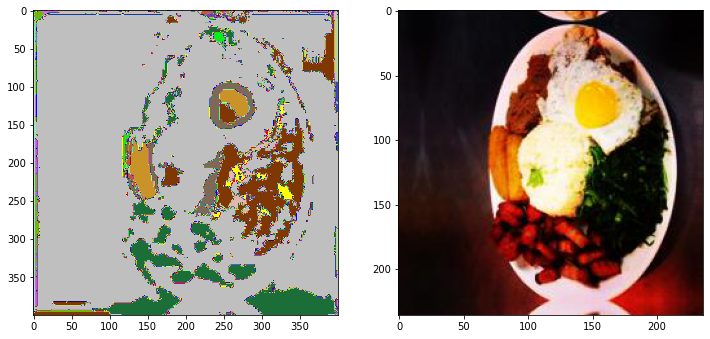

In [57]:
#input should be a PIL object

index = 2
img = dataloaders.valid_ds[index][0]

# img_pil = Image.open("3.jpg")
# img = np.asarray(img_pil.resize((400,400)))

learner = unet_learner(dataloaders, resnet34, loss_func=loss_func, opt_func=opt_func, metrics=None, cbs=modelCallbacks,
                       self_attention=True, act_cls=Mish)
learner.load('stage-3-best')
pred = learner.predict(img)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img)

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)